In [2]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

In [3]:
df_sample_submission = pd.read_csv('sample_submission.csv')
df_movies = pd.read_csv('movies.csv')
df_imdb = pd.read_csv('imdb_data.csv')
df_genome_scores = pd.read_csv('genome_scores.csv')
df_genome_tags = pd.read_csv('genome_tags.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_tags = pd.read_csv('tags.csv')
df_links = pd.read_csv('links.csv')

In [4]:
print(df_train.head())
print('-'*100)
print(df_train.info())

   userId  movieId  rating   timestamp
0    5163    57669     4.0  1518349992
1  106343        5     4.5  1206238739
2  146790     5459     5.0  1076215539
3  106362    32296     2.0  1423042565
4    9041      366     3.0   833375837
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB
None


In [23]:
# printing all the null values
print(df_train.isnull().sum(), 'train' + '\n')
print(df_test.isnull().sum(), 'test' + '\n')
print(df_genome_scores.isnull().sum(), 'genome_scores' + '\n')
print(df_genome_tags.isnull().sum(), 'genome_tags' + '\n')
print(df_movies.isnull().sum(), 'movies' + '\n')
print(df_links.isnull().sum(), 'links' + '\n')
print(df_imdb.isnull().sum(), 'imdb' + '\n')

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64 train

userId     0
movieId    0
dtype: int64 test

movieId      0
tagId        0
relevance    0
dtype: int64 genome_scores

tagId    0
tag      0
dtype: int64 genome_tags

movieId    0
title      0
genres     0
dtype: int64 movies

movieId      0
imdbId       0
tmdbId     107
dtype: int64 links

movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64 imdb



In [24]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])
movies_genres

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy
...,...,...
112302,209163,Drama
112303,209169,(no genres listed)
112304,209171,Action
112305,209171,Adventure


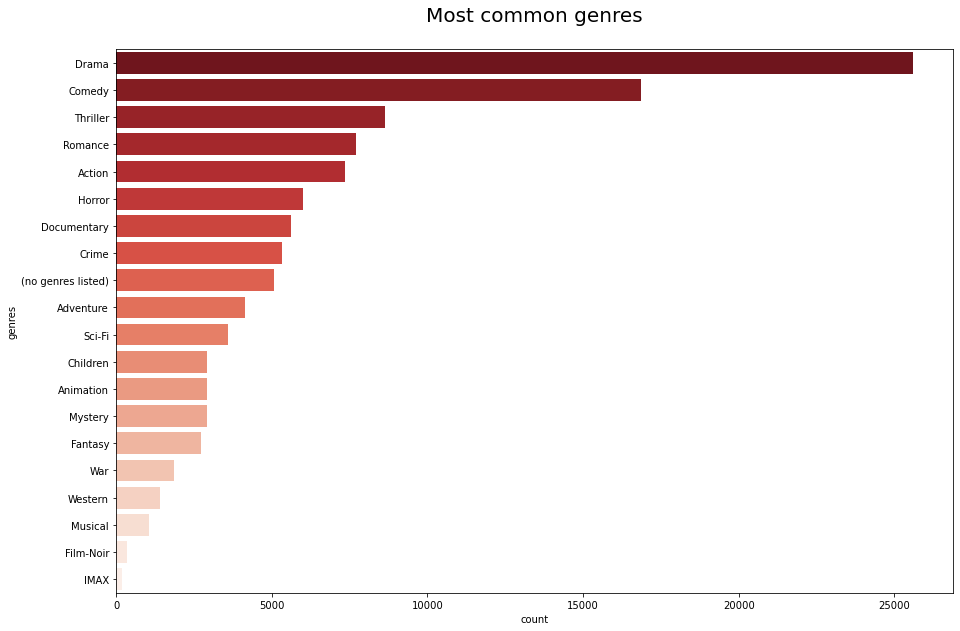

In [25]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

In [26]:
# Create dataframe containing only the movieId, title cast and keywords
df_imdb_clean = df_imdb[['movieId','title_cast']].fillna('No Cast')

df_imdb_clean.title_cast = df_imdb_clean.title_cast.apply(lambda x: x.split('|'))

df_imdb_clean = pd.DataFrame([(tup.movieId, d) for tup in df_imdb_clean.itertuples() for d in tup.title_cast],
                             columns=['movieId', 'title_cast'])
df_imdb_clean
#intent is to get most popular actors/actresses to drive the predictions

,movieId,title_cast
0,1,Tom Hanks
1,1,Tim Allen
2,1,Don Rickles
3,1,Jim Varney
4,1,Wallace Shawn
...,...,...
249353,131262,Mikal Evans
249354,131262,Daniel Zovatto
249355,131262,Evelina Turen
249356,131262,Rachel Heller


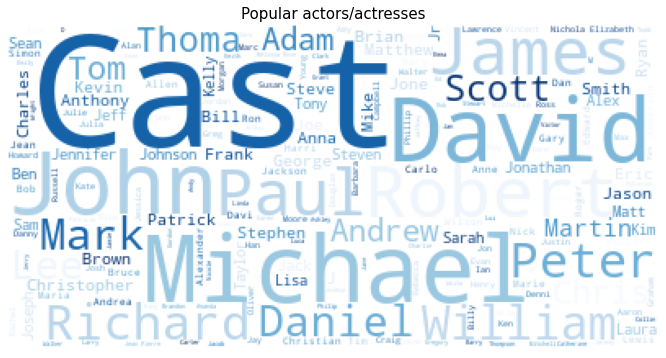

In [36]:
from wordcloud import WordCloud
fig = plt.subplots(figsize=(12,6))
wc_neg = WordCloud(background_color="white", colormap="Blues").generate(" ".join(
    df_imdb_clean['title_cast']))
plt.axis('off')
plt.title("Popular actors/actresses", fontsize=15)
plt.imshow(wc_neg)

In [32]:
# requires the most cleaning and has most about of data 
df_imdb

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion
...,...,...,...,...,...,...
27273,131254,Franz Dinda|Florian Lukas|Axel Stein|Kailas Ma...,Carsten Funke,85.0,NaN,man wrapped in a towel|man wears a thong|male ...
27274,131256,Rick Kavanian|Axel Stein|Eva Habermann|Christo...,Matthias Dinter,83.0,"DEM5,800,000",ski|ski resort|ampersand in title|drink in title
27275,131258,Nam-gil Kim|Ye-jin Son|Hae-Jin Yoo|Kyeong-yeon...,Seong-il Cheon,130.0,NaN,pirate|sword fight|korea|bandit
27276,131260,Martti Suosalo|Ilkka Koivula|Vexi Salmi|Riitta...,Timo Koivusalo,102.0,NaN,friend|friendship|television show|restaurant
